# EE 344 — Assignment 5: Power-System Fault Classification with Deep Neural Networks

In this assignment, you will predict **power-system fault conditions** from 6 input measurements using **PyTorch**.
There are many ways to implement DNNs for prediction tasks; here you will implement and compare **three** common setups.

**Dataset**: `classData.csv`

**Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`  
**Outputs**: 4-bit label `[G, C, B, A]`

Dataset (Kaggle): https://www.kaggle.com/datasets/esathyaprakash/electrical-fault-detection-and-classification

**Note:** Do **NOT** download the dataset from Kaggle. Use the dataset file provided on Canvas with this assignment.

Your tasks:
1. **Part 1** — Regression-style DNN to predict 4 outputs (then round to bits).
2. **Part 2** — Multi-label DNN to predict 4 bits (sigmoid / BCE-style loss).
3. **Part 3** — Multi-class DNN to predict no fault and 5 fault types (softmax / cross-entropy).
4. **Part 4** — Brief discussion: which approach is best and why.
5. **Part 5** — Open-ended: build a **binary** classifier (Fault vs No Fault) using the best approach.


## Setup
Run the next cell to import libraries and define helper functions.

In [33]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def plot_cm(cm, title, labels):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha='right')
    plt.yticks(ticks, labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def bit_reports(Y_true_bits, Y_pred_bits, split_name='Test', bit_names=('G','C','B','A')):
    """Multi-label report + per-bit 2x2 confusion matrices."""
    print(f"\n=== Bit-level Report | {split_name} ===")
    print(classification_report(Y_true_bits, Y_pred_bits, target_names=list(bit_names), digits=4))
    for j, lab in enumerate(bit_names):
        cm = confusion_matrix(Y_true_bits[:, j], Y_pred_bits[:, j], labels=[0, 1])
        print(f"\nBit {lab} | {split_name} CM (rows=true 0/1, cols=pred 0/1):\n{cm}")


Device: cpu


## Dataset

The file `classData.csv` contains a dataset for classifying fault conditions.

- **Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`
- **Outputs**: `[G, C, B, A]`

Examples:
- `[0 0 0 0]` — No Fault
- `[1 0 0 1]` — LG fault (Phase A to ground)
- `[0 0 1 1]` — LL fault (Phase A to Phase B)
- `[1 0 1 1]` — LLG fault (Phases A,B to ground)
- `[0 1 1 1]` — LLL fault (all three phases)
- `[1 1 1 1]` — LLLG fault (three phases + ground)


In [36]:
# ----------------------------
# Load data + create targets
# ----------------------------
CSV_PATH = 'classData.csv'
df = pd.read_csv(CSV_PATH)

label_cols = ['G','C','B','A']
feature_cols = ['Ia','Ib','Ic','Va','Vb','Vc']

missing = [c for c in (label_cols + feature_cols) if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}. Found: {list(df.columns)}")

X = df[feature_cols].astype(np.float32).values            # (N,6)
Y_bits = df[label_cols].astype(int).values                # (N,4)

FAULT_NAMES = ['No Fault','LG','LL','LLG','LLL','LLLG']

def bits_to_fault_type_idx(bits_gcba):
    G, C, B, A = map(int, bits_gcba)
    n_phase = C + B + A
    if G == 0 and n_phase == 0: return 0
    if G == 1 and n_phase == 1: return 1
    if G == 0 and n_phase == 2: return 2
    if G == 1 and n_phase == 2: return 3
    if G == 0 and n_phase == 3: return 4
    if G == 1 and n_phase == 3: return 5
    raise ValueError(f"Unexpected pattern [G,C,B,A]={bits_gcba}")

y_fault = np.array([bits_to_fault_type_idx(row) for row in Y_bits], dtype=int)
print('Fault counts:', dict(zip(FAULT_NAMES, np.bincount(y_fault, minlength=len(FAULT_NAMES)))))

# One shared split (recommended for fair comparison across Parts 1–3)
X_train, X_test, Y_train, Y_test, y_fault_train, y_fault_test = train_test_split(
    X, Y_bits, y_fault, test_size=0.30, random_state=RANDOM_STATE, stratify=y_fault
)
print('Train size:', X_train.shape[0], '| Test size:', X_test.shape[0])


Fault counts: {'No Fault': 2365, 'LG': 1129, 'LL': 1004, 'LLG': 1134, 'LLL': 1096, 'LLLG': 1133}
Train size: 5502 | Test size: 2359


## Part 1 — DNN Model 1 (Regression-style 4-output model)

You will build a DNN that outputs **4 real-valued numbers** and train it with **MSE**.
During evaluation, you will **round** predictions to the nearest integer, clamp to `{0,1}`, and then compare against the true 4-bit label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 (linear)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**


In [39]:
# ----------------------------
# Part 1: Robust scaling (fit on train only)
# ----------------------------
scaler_1 = RobustScaler()
X_train_s1 = scaler_1.fit_transform(X_train).astype(np.float32)
X_test_s1  = scaler_1.transform(X_test).astype(np.float32)

# Torch datasets
Xtr = torch.from_numpy(X_train_s1)
Xte = torch.from_numpy(X_test_s1)
Ytr = torch.from_numpy(Y_train.astype(np.float32))
Yte = torch.from_numpy(Y_test.astype(np.float32))

BATCH_SIZE = 256
train_loader_1 = DataLoader(TensorDataset(Xtr, Ytr), batch_size=BATCH_SIZE, shuffle=True)

# Hyperparameters
INPUT_DIM = 6
H1 = 16
H2 = 8
OUT_DIM = 4
DROPOUT_P = 0.25
L2_WEIGHT_DECAY = 1e-4
LR = 1e-3
EPOCHS = 1000


In [41]:
## [ TODO 1 ]
# Define the DNN for Part 1 using PyTorch.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: linear (no activation)
# - Use BatchNorm and Dropout in hidden layers
#
# Write your model class below.

class DNN_Reg4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        # First hidden layer block (Linear -> BatchNorm -> ReLU -> Dropout)
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(p_drop)
        
        # Second hidden layer block
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(p_drop)
        
        # Output layer (Linear, no activation)
        self.out = nn.Linear(h2, out_dim)

    def forward(self, x):
        x = self.drop1(self.relu1(self.bn1(self.fc1(x))))
        x = self.drop2(self.relu2(self.bn2(self.fc2(x))))
        x = self.out(x)
        return x


In [43]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: MSE
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
# TODO: loss_fn = ...
# TODO: optimizer = ...

# model = DNN_Reg4(...).to(device)
# loss_fn = ...
# optimizer = ...

model = DNN_Reg4().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)


In [51]:
# ----------------------------
# Training loop (you fill the key missing pieces)
# ----------------------------
## [ TODO 3 ]
def train_part1(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            # TODO: forward pass
            # TODO: compute loss
            # TODO: backward
            # TODO: optimizer step

            optimizer.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)
            

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            average_loss = total / len(loader.dataset)
            print(f"Epoch [{ep}/{epochs}], Loss: {average_loss: .4}")
            

@torch.no_grad()
def predict_part1(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    out = model(X_t).cpu().numpy()  # (N,4) real-valued
    return out

# TODO: Train the model
train_part1(model, train_loader_1)


Epoch [1/1000], Loss:  0.4775
Epoch [500/1000], Loss:  0.1022
Epoch [1000/1000], Loss:  0.103


In [72]:
# ----------------------------
# Evaluation (round -> clamp to {0,1} -> report)
# ----------------------------
yhat_train = predict_part1(model, X_train_s1)
yhat_test  = predict_part1(model, X_test_s1)

# After you obtain yhat_* (shape N x 4):
pred_bits_train = np.clip(np.rint(yhat_train).astype(int), 0, 1)
pred_bits_test  = np.clip(np.rint(yhat_test ).astype(int), 0, 1)
bit_reports(Y_train, pred_bits_train, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.8579    0.8355    0.8465      2377
           C     1.0000    0.8741    0.9328      2263
           B     0.9982    0.9205    0.9578      3057
           A     0.9806    0.9952    0.9878      3144

   micro avg     0.9616    0.9138    0.9371     10841
   macro avg     0.9592    0.9063    0.9312     10841
weighted avg     0.9627    0.9138    0.9369     10841
 samples avg     0.6709    0.6483    0.6548     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2796  329]
 [ 391 1986]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3239    0]
 [ 285 1978]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2440    5]
 [ 243 2814]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2296   62]
 [  15 3129]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.8495    0.8253    0.8372      1019
           C     1.0000    

C:\Users\echen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\echen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\echen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\echen\anaconda3\Lib\

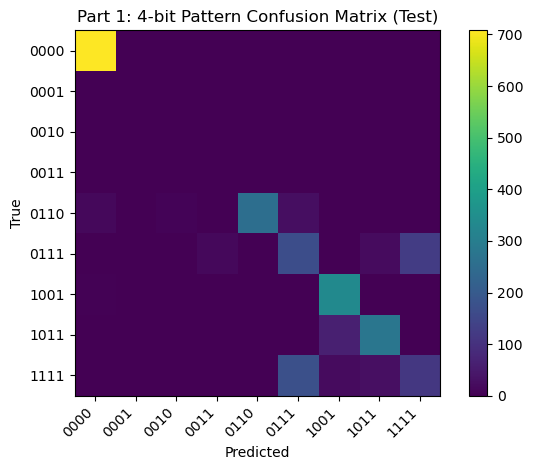

[[708   0   0   0   0   0   2   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 14   0   6   0 256  25   0   0   0]
 [  0   0   1  14   0 167   0  22 125]
 [  3   1   0   0   0   0 335   0   0]
 [  0   0   0   0   0   0  61 279   0]
 [  0   0   0   0   0 174  22  28 116]]


In [74]:
# One confusion matrix over full 4-bit patterns (for TEST set)
true_str = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str = [''.join(map(str, r.tolist())) for r in pred_bits_test]
labels = sorted(list(set(true_str) | set(pred_str)))
cm = confusion_matrix(true_str, pred_str, labels=labels)
plot_cm(cm, 'Part 1: 4-bit Pattern Confusion Matrix (Test)', labels)
print(cm)

## Part 2 — DNN Model 2 (Multi-label 4-bit classification)

You will build a DNN that predicts the 4 bits `[G, C, B, A]` as a **multi-label** output.
Each output dimension is an independent binary label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 logits (apply sigmoid only for evaluation)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use a **binary cross-entropy style loss on logits** (do not apply sigmoid inside the model).


In [61]:
# ----------------------------
# Part 2: Robust scaling (fit on train only)
# ----------------------------
scaler_2 = RobustScaler()
X_train_s2 = scaler_2.fit_transform(X_train).astype(np.float32)
X_test_s2  = scaler_2.transform(X_test).astype(np.float32)

Xtr2 = torch.from_numpy(X_train_s2)
Xte2 = torch.from_numpy(X_test_s2)
Ytr2 = torch.from_numpy(Y_train.astype(np.float32))
Yte2 = torch.from_numpy(Y_test.astype(np.float32))

train_loader_2 = DataLoader(TensorDataset(Xtr2, Ytr2), batch_size=BATCH_SIZE, shuffle=True)


In [63]:
## [ TODO 1 ]
# Define the DNN for Part 2.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: 4 logits (no sigmoid inside the model)
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiLabel4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(p_drop)
        
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(p_drop)
        
        # Output layer returning 4 logits
        self.out = nn.Linear(h2, out_dim)

    def forward(self, x):
        x = self.drop1(self.relu1(self.bn1(self.fc1(x))))
        x = self.drop2(self.relu2(self.bn2(self.fc2(x))))
        x = self.out(x)
        return x


In [65]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: binary cross-entropy style loss on logits -- BCEWithLogitsLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
# TODO: loss_fn = ...
# TODO: optimizer = ...

model = DNN_MultiLabel4().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)

In [67]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3]
def train_part2(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            # TODO: logits = model(xb)
            # TODO: loss = loss_fn(logits, yb)
            # TODO: backward + step
            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)
            

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            average_loss = total / len(loader.dataset)
            print(f"Epoch [{ep}/{epochs}], Loss: {average_loss: .4}") 

@torch.no_grad()
def predict_bits_part2(model, X_np, threshold=0.5):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy()
    pred_bits = (probs >= threshold).astype(int)
    return pred_bits

# TODO: Train the model
train_part2(model, train_loader_2)

Epoch [1/1000], Loss:  0.7417
Epoch [500/1000], Loss:  0.2302
Epoch [1000/1000], Loss:  0.2379


In [68]:
# ----------------------------
# Evaluation
# ----------------------------
pred_bits_train_ = predict_bits_part2(model, X_train_s2)
pred_bits_test_  = predict_bits_part2(model, X_test_s2)

bit_reports(Y_train, pred_bits_train_, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test_,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.7426    0.9962    0.8509      2377
           C     1.0000    0.8904    0.9420      2263
           B     0.9976    0.9339    0.9647      3057
           A     0.9539    0.9949    0.9740      3144

   micro avg     0.9137    0.9562    0.9345     10841
   macro avg     0.9235    0.9539    0.9329     10841
weighted avg     0.9295    0.9562    0.9377     10841
 samples avg     0.6517    0.6704    0.6560     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2304  821]
 [   9 2368]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3239    0]
 [ 248 2015]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2438    7]
 [ 202 2855]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2207  151]
 [  16 3128]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.7411    0.9971    0.8502      1019
           C     1.0000    

C:\Users\echen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\echen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\echen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\echen\anaconda3\Lib\

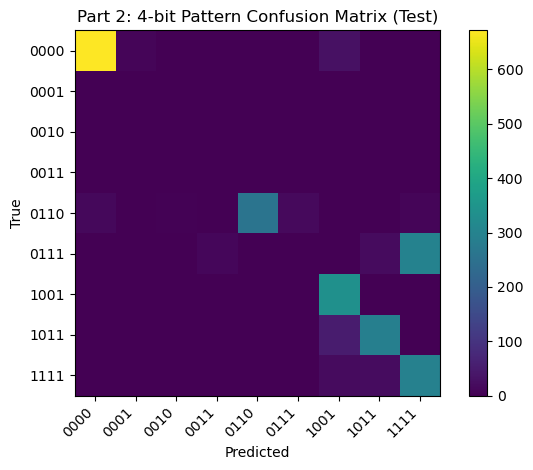

[[672   8   0   0   0   0  30   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 14   0   3   0 258  17   0   0   9]
 [  0   0   1  12   0   0   0  19 297]
 [  2   1   0   0   0   0 336   0   0]
 [  0   0   0   0   0   0  51 289   0]
 [  0   0   0   0   0   0  21  23 296]]


In [69]:
# One confusion matrix over full 4-bit patterns (For TEST set)
true_str_ = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str_ = [''.join(map(str, r.tolist())) for r in pred_bits_test_]
labels_ = sorted(list(set(true_str_) | set(pred_str_)))
cm_ = confusion_matrix(true_str_, pred_str_, labels=labels_)
plot_cm(cm_, 'Part 2: 4-bit Pattern Confusion Matrix (Test)', labels_)
print(cm_)

## Part 3 — DNN Model 3 (Multi-class fault type classification)

In this part, you will predict one of **6 fault types**.
The 4-bit label is converted to a single class in `{0,1,2,3,4,5}` using the provided mapping.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 6 logits
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use **cross-entropy loss** for multi-class classification.


In [81]:
# ----------------------------
# Part 3: Robust scaling (fit on train only)
# ----------------------------
scaler_3 = RobustScaler()
X_train_s3 = scaler_3.fit_transform(X_train).astype(np.float32)
X_test_s3  = scaler_3.transform(X_test).astype(np.float32)

ytr3 = torch.from_numpy(y_fault_train.astype(np.int64))
yte3 = torch.from_numpy(y_fault_test.astype(np.int64))
Xtr3 = torch.from_numpy(X_train_s3)
Xte3 = torch.from_numpy(X_test_s3)

train_loader_3 = DataLoader(TensorDataset(Xtr3, ytr3), batch_size=BATCH_SIZE, shuffle=True)


In [83]:
## [ TODO 1 ]
# Define the DNN for Part 3.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 6
# - Hidden activations: ReLU
# - Output: 6 logits
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiClass6(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, num_classes=6, p_drop=DROPOUT_P):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(p_drop)
        
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(p_drop)
        
        # Output layer returning 6 logits
        self.out = nn.Linear(h2, num_classes)

    def forward(self, x):
        x = self.drop1(self.relu1(self.bn1(self.fc1(x))))
        x = self.drop2(self.relu2(self.bn2(self.fc2(x))))
        x = self.out(x)
        return x


In [85]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: CrossEntropyLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
# TODO: loss_fn = ...
# TODO: optimizer = ...

model = DNN_MultiClass6().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)

In [87]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3 ]
def train_part3(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            # TODO: logits = model(xb)
            # TODO: loss = loss_fn(logits, yb)
            # TODO: backward + step

            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()
            
            total += loss.item() * xb.size(0)

        if ep in [1, epochs//2, epochs]:
            average_loss = total / len(loader.dataset)
            print(f"Epoch [{ep}/{epochs}], Loss: {average_loss: .4}")
            

@torch.no_grad()
def predict_part3(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    return torch.argmax(logits, dim=1).cpu().numpy()

# TODO: Train the model
train_part3(model, train_loader_3)

Epoch [1/1000], Loss:  1.798
Epoch [500/1000], Loss:  0.609
Epoch [1000/1000], Loss:  0.6145



=== Part 3 | Train ===
              precision    recall  f1-score   support

    No Fault     0.9555    1.0000    0.9773      1655
          LG     0.8382    0.9506    0.8909       790
          LL     0.9129    0.9388    0.9257       703
         LLG     0.8988    0.8728    0.8856       794
         LLL     0.5139    0.9166    0.6585       767
        LLLG     0.8333    0.0126    0.0248       793

    accuracy                         0.8128      5502
   macro avg     0.8254    0.7819    0.7271      5502
weighted avg     0.8459    0.8128    0.7633      5502



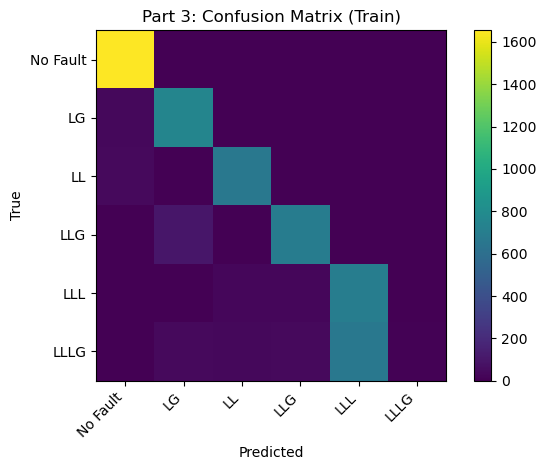


=== Part 3 | Test ===
              precision    recall  f1-score   support

    No Fault     0.9479    1.0000    0.9733       710
          LG     0.8364    0.9499    0.8895       339
          LL     0.9183    0.9336    0.9259       301
         LLG     0.9221    0.8706    0.8956       340
         LLL     0.5009    0.8906    0.6411       329
        LLLG     0.6154    0.0235    0.0453       340

    accuracy                         0.8097      2359
   macro avg     0.7902    0.7780    0.7285      2359
weighted avg     0.8141    0.8097    0.7639      2359



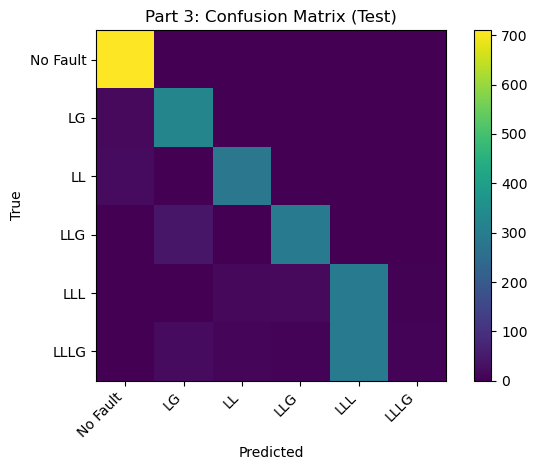

In [89]:
# ----------------------------
# Evaluation
# ----------------------------
pred_train = predict_part3(model, X_train_s3)
pred_test  = predict_part3(model, X_test_s3)

print('\n=== Part 3 | Train ===')
print(classification_report(y_fault_train, pred_train, target_names=FAULT_NAMES, digits=4))
cm_tr = confusion_matrix(y_fault_train, pred_train, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_tr, 'Part 3: Confusion Matrix (Train)', FAULT_NAMES)

print('\n=== Part 3 | Test ===')
print(classification_report(y_fault_test, pred_test, target_names=FAULT_NAMES, digits=4))
cm_te = confusion_matrix(y_fault_test, pred_test, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_te, 'Part 3: Confusion Matrix (Test)', FAULT_NAMES)


## Part 4 — Discussion

Answer **2–5 sentences** for each prompt.

1. Compare Parts 1–3. Which formulation fits this dataset best (regression-style, multi-label, or multi-class), and why?
2. When you used the bit-based approaches (Part 1 and Part 2), did you observe any **inconsistent 4-bit outputs** (invalid fault patterns)? What does that suggest?
3. Looking at confusion matrices, which fault types (or bit positions) were the hardest to predict? Give one plausible reason.

### Your answers
- Q1: Part 3 formula (multi-class) fits the dataset best because it's able to categorize data into specific fault types and only predict valid combinations. Compare this to the other two formulas that predict each bit individually leading to impossible combinations and unneccassary predictions.
- Q2: Yes, looking at the x axis prediction labels in confusion matrix shows impossible fault patterns such as 0001, 0010, and 0110. This suggest that the formula's intentions is simply minimizing mathematical error bit by bit and unable to evaulat mutually exclusive fault conditions.
- Q3: LLLG and LLL was the hardest to predict seen by the confusion matrix seeming to misclassify LLLG into LLL. This might be because LLL is mathematically balanced fault with the phase current summing to zero or close. Adding ground doesn't change electrical measurements thus it makes LLL and LLLG look almost identical.


## Part 5 — Open-ended extension: Binary classification (Fault vs No Fault)

In this part, you will create a **binary** classification problem:

- Class 0: **No Fault** (`[0,0,0,0]`)
- Class 1: **Fault** (any other pattern)

**Your task**: Using the best formulation you identified in Part 4, build a DNN to classify **Fault vs No Fault**.

Requirements:
- Use a **70% / 30%** train/test split (stratified)
- Use **RobustScaler** (fit on train only)
- Report **classification report** and **confusion matrix** on **train and test**

Implementation notes:
- First create a dataset with two classes by compressing all fault types into a single “Fault” class (and keeping “No Fault” as the other class).
- Keep your solution clean and focused: data, model, training, evaluation.


Epoch [1/1000], Loss: 1.1961
Epoch [500/1000], Loss: 0.0789
Epoch [1000/1000], Loss: 0.0742

=== Part 5 | Train ===
              precision    recall  f1-score   support

    No Fault     0.9729    0.9994    0.9860      1655
       Fault     0.9997    0.9880    0.9939      3847

    accuracy                         0.9915      5502
   macro avg     0.9863    0.9937    0.9899      5502
weighted avg     0.9917    0.9915    0.9915      5502



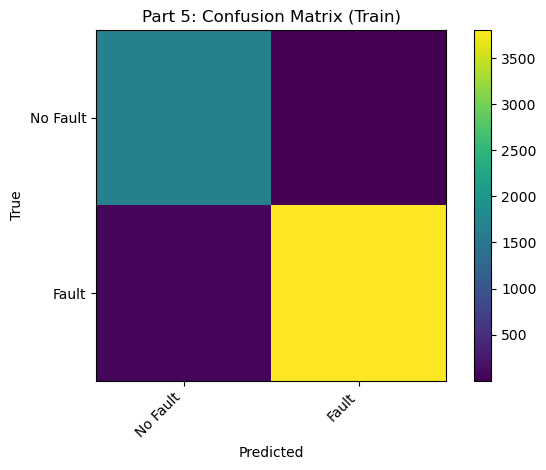


=== Part 5 | Test ===
              precision    recall  f1-score   support

    No Fault     0.9726    0.9986    0.9854       710
       Fault     0.9994    0.9879    0.9936      1649

    accuracy                         0.9911      2359
   macro avg     0.9860    0.9932    0.9895      2359
weighted avg     0.9913    0.9911    0.9911      2359



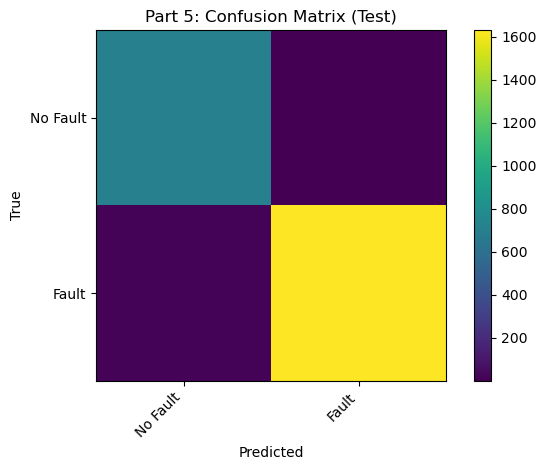

In [93]:
# 1. DATA PREP: Create Binary Labels & Split
y_binary = (y_fault != 0).astype(int)

# 70/30 Stratified Split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X, y_binary, test_size=0.30, random_state=RANDOM_STATE, stratify=y_binary
)
scaler_b = RobustScaler()
X_train_sb = scaler_b.fit_transform(X_train_b).astype(np.float32)
X_test_sb  = scaler_b.transform(X_test_b).astype(np.float32)

Xtr_b = torch.from_numpy(X_train_sb)
Xte_b = torch.from_numpy(X_test_sb)
ytr_b = torch.from_numpy(y_train_b.astype(np.int64))
yte_b = torch.from_numpy(y_test_b.astype(np.int64))

train_loader_b = DataLoader(TensorDataset(Xtr_b, ytr_b), batch_size=BATCH_SIZE, shuffle=True)

# 2. MODEL DEFINITION
class DNN_Binary(nn.Module):
    def __init__(self, input_dim=6, h1=16, h2=8, num_classes=2, p_drop=0.25):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(p_drop)
        
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(p_drop)
        
        self.out = nn.Linear(h2, num_classes)

    def forward(self, x):
        x = self.drop1(self.relu1(self.bn1(self.fc1(x))))
        x = self.drop2(self.relu2(self.bn2(self.fc2(x))))
        x = self.out(x)
        return x


# 3. TRAINING LOOP
model_b = DNN_Binary().to(device)
loss_fn_b = nn.CrossEntropyLoss()
optimizer_b = torch.optim.Adam(model_b.parameters(), lr=1e-3, weight_decay=1e-4)

epochs = 1000
model_b.train()
for ep in range(1, epochs + 1):
    total = 0.0
    for xb, yb in train_loader_b:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer_b.zero_grad()
        logits = model_b(xb)
        loss = loss_fn_b(logits, yb)
        loss.backward()
        optimizer_b.step()

        total += loss.item() * xb.size(0)

    if ep in [1, epochs//2, epochs]:
        avg_loss = total / len(train_loader_b.dataset)
        print(f"Epoch [{ep}/{epochs}], Loss: {avg_loss:.4f}")


# 4. EVALUATION: Train & Test Reports
@torch.no_grad()
def predict_binary(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np).to(device)
    logits = model(X_t)
    return torch.argmax(logits, dim=1).cpu().numpy()

pred_train_b = predict_binary(model_b, X_train_sb)
pred_test_b  = predict_binary(model_b, X_test_sb)

bin_names = ['No Fault', 'Fault']

print('\n=== Part 5 | Train ===')
print(classification_report(y_train_b, pred_train_b, target_names=bin_names, digits=4))
cm_tr_b = confusion_matrix(y_train_b, pred_train_b)
plot_cm(cm_tr_b, 'Part 5: Confusion Matrix (Train)', bin_names)

print('\n=== Part 5 | Test ===')
print(classification_report(y_test_b, pred_test_b, target_names=bin_names, digits=4))
cm_te_b = confusion_matrix(y_test_b, pred_test_b)
plot_cm(cm_te_b, 'Part 5: Confusion Matrix (Test)', bin_names)